In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
# plt.rcParams["figure.figsize"] = [1, 5]
plt.rcParams["figure.dpi"] = 100
plt.style.use('seaborn-notebook')
sns.set_style("ticks")
sns.despine(offset=10, trim=True)

import warnings
warnings.filterwarnings('ignore')
from time import sleep

from math import sqrt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, GRU
from keras.models import load_model
from keras.callbacks import Callback

import ccxt
import exchange_poloniex as expx

Using TensorFlow backend.


In [2]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();

plot_learning = PlotLearning()

In [3]:
# convert series to supervised classification learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
def transform_classificaiton(vals):
    d = []
    o = vals[0]
    for n in vals[1:]:
#         d += [o-n]
        o = n
    return np.asarray(d)

In [5]:
# save new data
# expx.save_df(days_back = 90)
            
# load dataset
dataset = expx.load_df()[['open']]
values = dataset.values.astype('float32')
# values = transform_classificaiton(values)

# specify the number of lag hours
n_timesteps_in = 12*1
n_timesteps_out = 1

# frame as supervised learning
reframed = series_to_supervised(data = values, n_in = n_timesteps_in, n_out = n_timesteps_out)

print(reframed.shape)
reframed.head()

(25846, 73)


,var1(t-72),var1(t-71),var1(t-70),var1(t-69),var1(t-68),var1(t-67),var1(t-66),var1(t-65),var1(t-64),var1(t-63),...,var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
72,64.0,0.0,-177.0,104.0,2.0,-2.0,2.0,0.0,0.0,0.0,...,7.0,3.0,1.0,0.0,45.0,0.0,0.0,53.0,0.0,0.0
73,0.0,-177.0,104.0,2.0,-2.0,2.0,0.0,0.0,0.0,-1.0,...,3.0,1.0,0.0,45.0,0.0,0.0,53.0,0.0,0.0,0.0
74,-177.0,104.0,2.0,-2.0,2.0,0.0,0.0,0.0,-1.0,1.0,...,1.0,0.0,45.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0
75,104.0,2.0,-2.0,2.0,0.0,0.0,0.0,-1.0,1.0,-1.0,...,0.0,45.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,-5.0
76,2.0,-2.0,2.0,0.0,0.0,0.0,-1.0,1.0,-1.0,-49.0,...,45.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,-5.0,-4.0


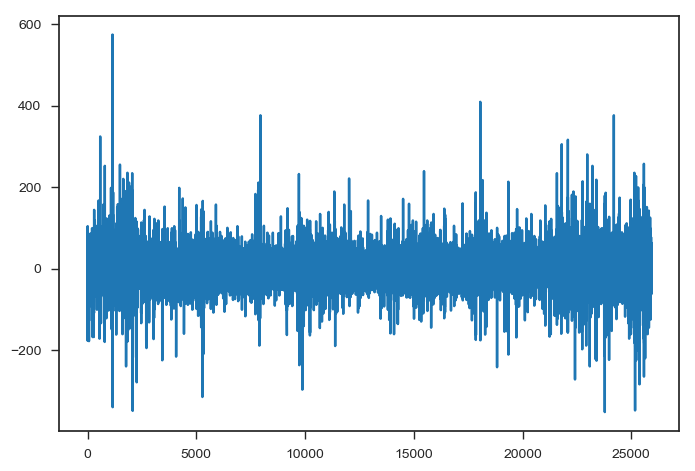

In [6]:
plt.plot(values)

In [7]:
# split into train and test sets
values = reframed.values
tts = int(len(values) * 0.7)
train = values[:tts, :]
test = values[tts:, :]
# split into input and outputs
n_features = int(reframed.shape[1]/(n_timesteps_in+1))
n_obs = n_timesteps_in * n_features
n_prd = reframed.shape[1] - n_obs
train_X, train_y = train[:, :n_obs], train[:, -n_prd:]
test_X, test_y = test[:, :n_obs], test[:, -n_prd:]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_timesteps_in, n_features))
# train_y = train_y.reshape((train_y.shape[0], n_timesteps_out, n_features))
test_X = test_X.reshape((test_X.shape[0], n_timesteps_in, n_features))
# test_y = test_y.reshape((test_y.shape[0], n_timesteps_out, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(18092, 72) 18092 (18092, 1)
(18092, 72, 1) (18092, 1) (7754, 72, 1) (7754, 1)


In [8]:
from keras import callbacks
from keras.wrappers.scikit_learn import KerasClassifier

def create_network(num_gru_units, num_gru_layers, gru_activation, num_dense_units, num_dense_layers, dense_activation, dense_dropout, output_activation):
#     tbcallback = callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
#     early_stopping_monitor = callbacks.EarlyStopping(patience=2)

    # design network
    model = Sequential()
    # model.add(Dense(64, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(GRU(num_gru_units, input_shape=(train_X.shape[1], train_X.shape[2]), activation=gru_activation, return_sequences=True))
    for x in range(num_gru_layers):
        model.add(GRU(num_gru_units, activation=gru_activation, return_sequences=True))  # returns a sequence of vectors of dimension 32
    model.add(GRU(num_gru_units, activation=gru_activation))  # return a single vector of dimension 32
    for x in range(num_dense_layers):
        model.add(Dense(num_dense_units, activation=dense_activation))
        model.add(Dropout(dense_dropout))
    model.add(Dense(output_dim = train_y.shape[1], activation = output_activation)) #Output layer
    model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

neural_network = KerasClassifier(build_fn=create_network, verbose=1)

In [9]:
hyperparameters = {
    'num_gru_units': [8, 32, 64],
    'num_gru_layers': [0, 1, 3, 5],
    'gru_activation': ['relu', 'tahn', 'sigmoid', 'linear'],
    'num_dense_units': [8, 32, 64],
    'num_dense_layers': np.arange(0, 5, 1),
    'dense_activation': ['relu', 'tahn', 'sigmoid', 'linear'],
    'dense_dropout': [0.0, 0.001, 0.01, 0.1, 0.3],
    'output_activation': ['relu', 'tahn', 'sigmoid', 'linear']
}

fit_parameters = {
    'validation_data': [(test_X, test_y)],
    'batch_size': [256, 4096],
    'epochs': [1000]
}

t = 0
for k, v in hyperparameters.items():
    if t == 0:
        t = len(v)
    t = t * len(v)
print(t)

172800


In [10]:
# from sklearn.model_selection import GridSearchCV

# # Create grid search
# grid = GridSearchCV(estimator=neural_network, param_grid=hyperparameters, verbose=50, n_jobs=1)

# # Fit grid search
# grid_result = grid.fit(X=train_X, y=train_y, fit_params=fit_parameters)

model = create_network(num_gru_units = 32, num_gru_layers = 3, gru_activation = 'linear', num_dense_units = 16, num_dense_layers = 5, dense_activation = 'linear', dense_dropout = 0.0, output_activation = 'linear')

In [11]:
# grid_result.best_params_

In [13]:
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(test_X, test_y), verbose=1, shuffle=False, callbacks=[plot_learning])

Train on 18092 samples, validate on 7754 samples
Epoch 1/100


InternalError: Blas GEMM launch failed : a.shape=(16, 32), b.shape=(32, 32), m=16, n=32, k=32
	 [[Node: gru_1/while/MatMul_3 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gru_1/while/Switch_2:1, gru_1/while/MatMul_3/Enter)]]
	 [[Node: loss/mul/_221 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_6971_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'gru_1/while/MatMul_3', defined at:
  File "C:\Users\Trey\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\Trey\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\Trey\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\Trey\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\Trey\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\Trey\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\Trey\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\Trey\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-69ebdd1415f0>", line 9, in <module>
    model = create_network(num_gru_units = 32, num_gru_layers = 3, gru_activation = 'linear', num_dense_units = 16, num_dense_layers = 5, dense_activation = 'linear', dense_dropout = 0.0, output_activation = 'linear')
  File "<ipython-input-8-c34540ab43bf>", line 11, in create_network
    model.add(GRU(num_gru_units, input_shape=(train_X.shape[1], train_X.shape[2]), activation=gru_activation, return_sequences=True))
  File "C:\Users\Trey\Anaconda3\lib\site-packages\keras\models.py", line 464, in add
    layer(x)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 482, in __call__
    return super(RNN, self).__call__(inputs, **kwargs)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\keras\engine\topology.py", line 603, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 1515, in call
    initial_state=initial_state)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 589, in call
    input_length=timesteps)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2646, in rnn
    swap_memory=True)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2816, in while_loop
    result = loop_context.BuildLoop(cond, body, loop_vars, shape_invariants)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2640, in BuildLoop
    pred, body, original_loop_vars, loop_vars, shape_invariants)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py", line 2590, in _BuildLoop
    body_result = body(*packed_vars_for_body)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 2632, in _step
    tuple(constants))
  File "C:\Users\Trey\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 580, in step
    return self.cell.call(inputs, states, **kwargs)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\keras\layers\recurrent.py", line 1333, in call
    self.recurrent_kernel_z))
  File "C:\Users\Trey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 1057, in dot
    out = tf.matmul(x, y)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1891, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2436, in _mat_mul
    name=name)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 2956, in create_op
    op_def=op_def)
  File "C:\Users\Trey\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InternalError (see above for traceback): Blas GEMM launch failed : a.shape=(16, 32), b.shape=(32, 32), m=16, n=32, k=32
	 [[Node: gru_1/while/MatMul_3 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](gru_1/while/Switch_2:1, gru_1/while/MatMul_3/Enter)]]
	 [[Node: loss/mul/_221 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_6971_loss/mul", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


0


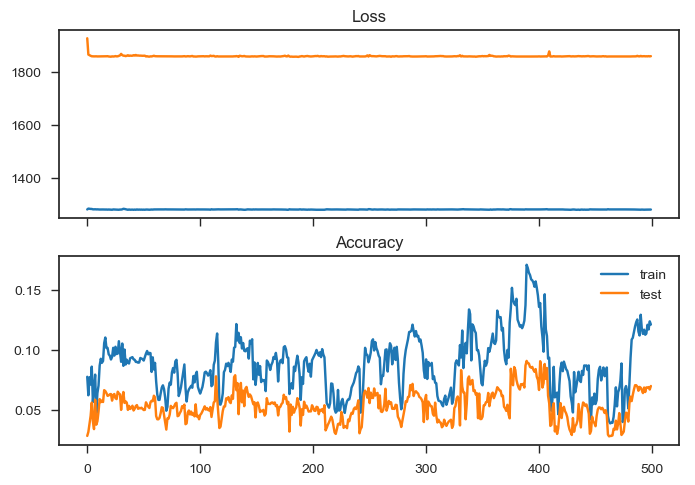

1


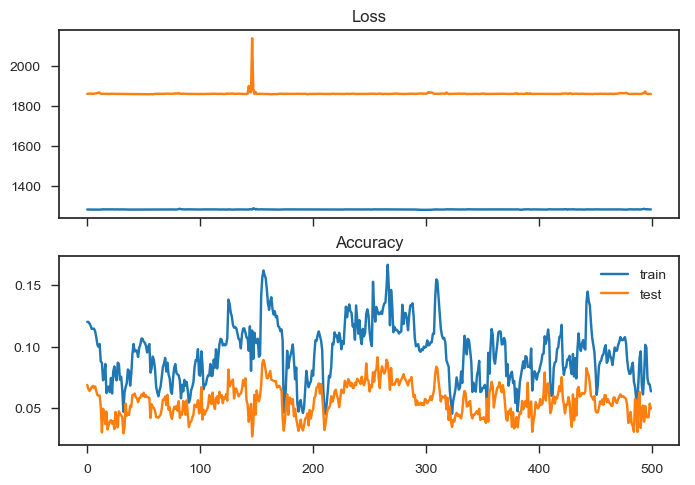

KeyboardInterrupt: 

In [30]:
for x in range(20):
    history = model.fit(train_X, train_y, epochs=500, batch_size=512, validation_data=(test_X, test_y), verbose=0, shuffle=False)
    print(x)
    
    view = 0
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

    ax1.set_title('Loss')
    ax1.plot(history.history['loss'][-view:], label='train')
    ax1.plot(history.history['val_loss'][-view:], label='test')

    ax2.set_title('Accuracy')
    ax2.plot(history.history['acc'][-view:], label='train')
    ax2.plot(history.history['val_acc'][-view:], label='test')

    plt.legend()
    plt.show()

In [ ]:
# model.save('model_attempt4.h5')

In [ ]:
# plot training
view = 0
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.set_title('Loss')
ax1.plot(history.history['loss'][-view:], label='train')
ax1.plot(history.history['val_loss'][-view:], label='test')

ax2.set_title('Accuracy')
ax2.plot(history.history['acc'][-view:], label='train')
ax2.plot(history.history['val_acc'][-view:], label='test')

plt.legend()
plt.show()

In [31]:
model.evaluate(x=test_X, y=test_y)

7754/7754 [==============================] - 17s 2ms/step


[1861.2786199940151, 0.045524890381080881]

In [32]:
def predict(df, points):
    before = df[:, 0, -1].flatten()
    plt.plot(before, label='before')
    for point in points:
        after = model.predict(df[:point])[-1]
        padding = [None for p in range(point+1)]
        plt.plot(np.concatenate([padding, after]), label='after')
    plt.legend()
    plt.show() 

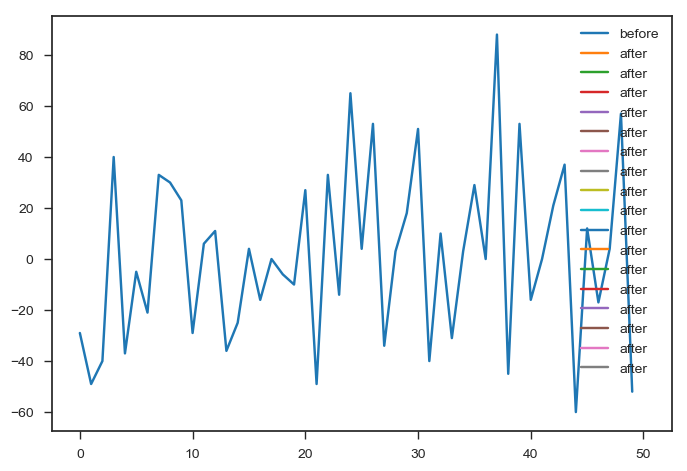

In [33]:
# print(test_X.shape)
# print(test_X[:1].shape)
predict(test_X[0:50], range(1, 50, 3))

temp [[[ -29.]
  [   6.]
  [  11.]
  [ -36.]
  [ -25.]
  [   4.]
  [ -16.]
  [   0.]
  [  -6.]
  [ -10.]
  [  27.]
  [ -49.]
  [  33.]
  [ -14.]
  [  65.]
  [   4.]
  [  53.]
  [ -34.]
  [   3.]
  [  18.]
  [  51.]
  [ -40.]
  [  10.]
  [ -31.]
  [   3.]
  [  29.]
  [   0.]
  [  88.]
  [ -45.]
  [  53.]
  [ -16.]
  [   0.]
  [  21.]
  [  37.]
  [ -60.]
  [  12.]
  [ -17.]
  [   4.]
  [  57.]
  [ -52.]
  [  13.]
  [  43.]
  [ -39.]
  [  50.]
  [  -1.]
  [  18.]
  [   3.]
  [   7.]
  [  18.]
  [  -9.]
  [  35.]
  [  27.]
  [   9.]
  [  32.]
  [  -8.]
  [  35.]
  [  23.]
  [  47.]
  [ -13.]
  [-100.]
  [ -21.]
  [  -3.]
  [ -18.]
  [  15.]
  [ 217.]
  [   6.]
  [  23.]
  [ -11.]
  [  19.]
  [ -75.]
  [  39.]
  [ -38.]]]
test_y[5:6] [[-11.]]
aaa [[ 0.44189346]]
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, Non

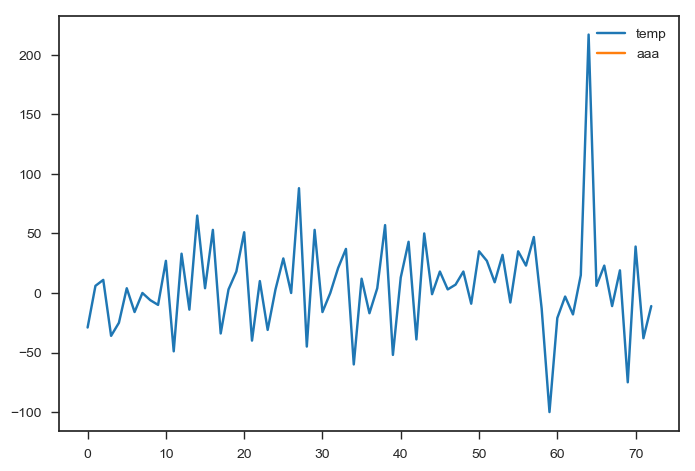

In [34]:
temp = test_X[10:11]
print('temp', temp)
print('test_y[5:6]', test_y[10:11])
aaa = model.predict(temp)
print('aaa', aaa)
padding = [None for p in range(len(temp.flatten()))]
print(padding)
plt.plot(np.concatenate([temp.flatten(), test_y[10:11].flatten()]), label='temp')
plt.plot(np.concatenate([padding, aaa[0]]), label='aaa')
plt.legend()
plt.show() 